In [1]:
# Importing standard Qiskit libraries 
from qiskit import *
from qiskit import IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use('dark_background')

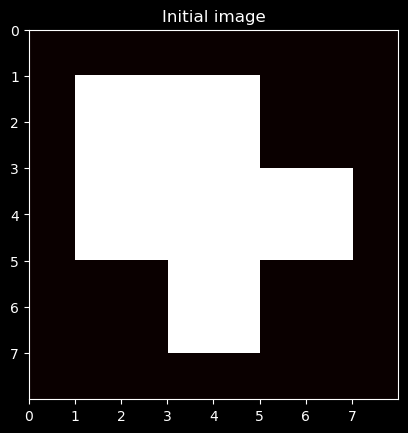

In [2]:
# representing a binary image(8x8) in form of a numpy array

img = np.array([  [0, 0, 0, 0, 0, 0, 0, 0],
                  [0, 1, 1, 1, 1, 0, 0, 0],
                  [0, 1, 1, 1, 1, 0, 0, 0],
                  [0, 1, 1, 1, 1, 1, 1, 0],
                  [0, 1, 1, 1, 1, 1, 1, 0],
                  [0, 0, 0, 1, 1, 0, 0, 0],
                  [0, 0, 0, 1, 1, 0, 0, 0],
                  [0, 0, 0, 0, 0, 0, 0, 0] ])


# plot image function

def plot_image(Image, title):
    plt.title(title)
    plt.xticks(range(Image.shape[0]))
    plt.yticks(range(Image.shape[1]))
    plt.imshow(Image, extent=[  0,Image.shape[0], Image.shape[1],0,], cmap='hot')
    plt.show()
    
plot_image(img, 'Initial image')

In [3]:
#we encode the intensities of image pixels as probability amplitudes of quantum states
#we use normalization for this
#we normalize the amplitudes to lie in the range (0,1)

# Convert the raw pixel values to probability amplitudes
def amplitude_encode(img_data):
    
    # Calculate the RMS value
    rms = np.sqrt(np.sum(np.sum(img_data**2, axis=1)))
    
    # Create normalized image
    image_norm = []
    for arr in img_data:
        for ele in arr:
            image_norm.append(ele / rms)
        
    # Return the normalized image as a numpy array
    return np.array(image_norm)


#we now normalize image and get coefficients in both horizontal and vertical directions

# Horizontal: Original image
h_norm_image = amplitude_encode(img)
print("Horizontal image normalized coefficients",h_norm_image)


print()
print()

# Vertical: Transpose of Original image
v_norm_image = amplitude_encode(img.T)
print("vertical image normalized coefficients",v_norm_image)

print()
print("size of 1d array",h_norm_image.shape)
print("size of 1d array",v_norm_image.shape)

Horizontal image normalized coefficients [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.20412415 0.20412415 0.20412415
 0.20412415 0.         0.         0.         0.         0.20412415
 0.20412415 0.20412415 0.20412415 0.         0.         0.
 0.         0.20412415 0.20412415 0.20412415 0.20412415 0.20412415
 0.20412415 0.         0.         0.20412415 0.20412415 0.20412415
 0.20412415 0.20412415 0.20412415 0.         0.         0.
 0.         0.20412415 0.20412415 0.         0.         0.
 0.         0.         0.         0.20412415 0.20412415 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]


vertical image normalized coefficients [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.20412415 0.20412415 0.20412415
 0.20412415 0.         0.         0.         0.         0.20412415
 0.20412415 0.20412415 0.20412415 0.         0.         0

In [4]:
#we require N=log(8*8) qubits 
#N=6

data_q = 6
ancillary_q = 1
total_q = data_q + ancillary_q

# Initialize the amplitude permutation unitary
Amp_permutation_unitary = np.identity(2**total_q)
print(Amp_permutation_unitary)
Amp_permutation_unitary=np.roll(Amp_permutation_unitary,1,axis=1)
print()
print()
print()
print("shift Amplitude permutation matrix by 1 unit to the right column wise")
print()
print(Amp_permutation_unitary)
print()
print("we will later use this for while applying hadamard operation to image coefficient vectors")
print()
print(Amp_permutation_unitary.shape)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]



shift Amplitude permutation matrix by 1 unit to the right column wise

[[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [1. 0. 0. ... 0. 0. 0.]]

we will later use this for while applying hadamard operation to image coefficient vectors

(128, 128)


In [5]:
!pip install pylatexenc


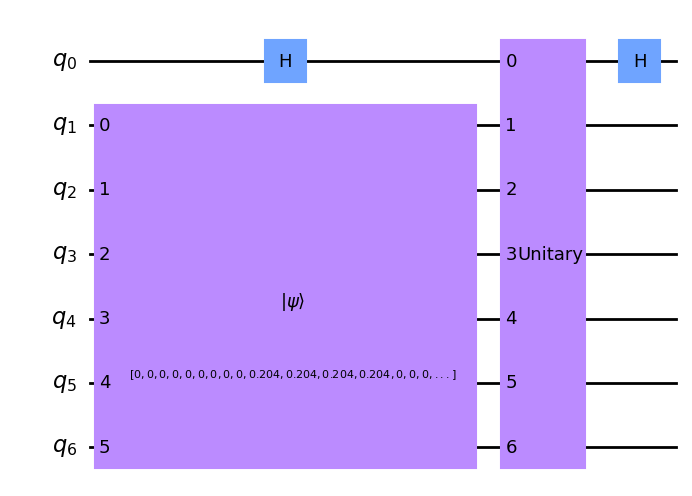

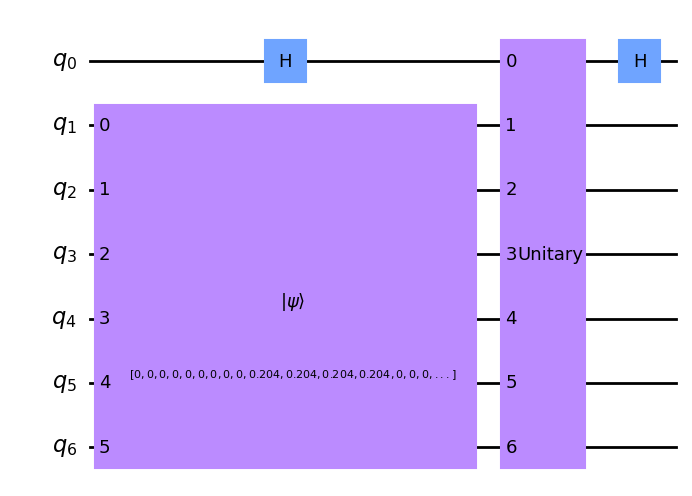

In [6]:
#applying hadaram detection now:

# Creating the circuit for horizontal scan

qc_h = QuantumCircuit(total_q)
qc_h.initialize(h_norm_image, range(1, total_q))
qc_h.h(0)
qc_h.unitary(Amp_permutation_unitary, range(total_q))
qc_h.h(0)

display(qc_h.draw('mpl', fold=-1))


# Create the circuit for vertical scan
qc_v = QuantumCircuit(total_q)
qc_v.initialize(v_norm_image, range(1, total_q))
qc_v.h(0)
qc_v.unitary(Amp_permutation_unitary, range(total_q))
qc_v.h(0)

display(qc_v.draw('mpl', fold=-1))

# Combine both circuits into a single list
circ_list = [qc_h, qc_v]

In [7]:
# Simulating cirucits
back = Aer.get_backend('statevector_simulator')
results = execute(circ_list, backend=back).result()
state_vector_h = results.get_statevector(qc_h)
state_vector_v = results.get_statevector(qc_v)
print("print size is ",state_vector_h.size)
from qiskit.visualization import array_to_latex
print('Horizontal scan statevector:')
display(array_to_latex(state_vector_h, max_size=128))
print()
print('Vertical scan statevector:')
display(array_to_latex(state_vector_v, max_size=128))

C:\Users\admin\AppData\Local\Temp\ipykernel_74724\2583882967.py:6: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
  print("print size is ",state_vector_h.size)


print size is  128
Horizontal scan statevector:


<IPython.core.display.Latex object>


Vertical scan statevector:


<IPython.core.display.Latex object>

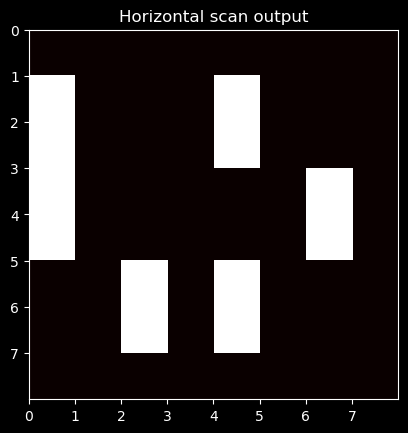

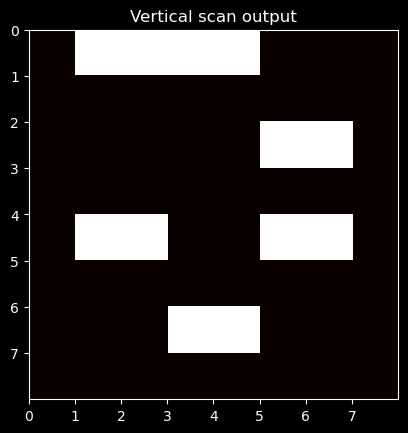

In [8]:
#  postprocessing for plotting the output (Classical)

# Defining a lambda function for thresholding to binary values
# returns true for specified Amplitude values else false
threshold = lambda amp: (amp > 1e-15 or amp < -1e-15)

# Selecting odd states from the raw statevector and
# reshaping column vector of size 64 to an 8x8 matrix
h_edge_scan_img = np.abs(np.array([1 if threshold(state_vector_h[(2*i)+1].real) else 0 for i in range(2**data_q)])).reshape(8, 8)
v_edge_scan_img= np.abs(np.array([1 if threshold(state_vector_v[(2*i)+1].real) else 0 for i in range(2**data_q)])).reshape(8, 8).T

# Plotting the Horizontal and vertical scans
plot_image(h_edge_scan_img, 'Horizontal scan output')
plot_image(v_edge_scan_img, 'Vertical scan output')

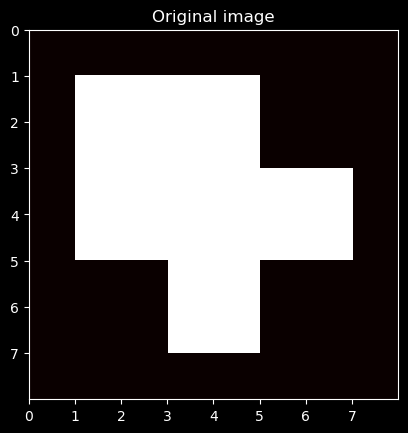

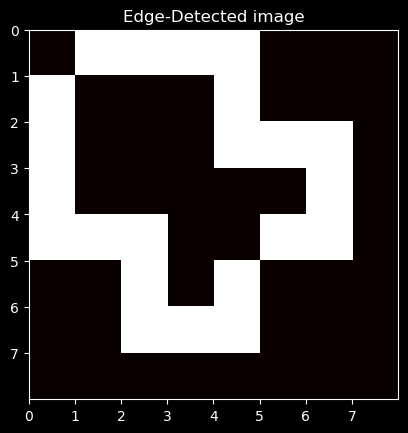

In [9]:
# Combining the horizontal and vertical component of the result by or operator
edge_scan_image = h_edge_scan_img | v_edge_scan_img

# Plotting the original and edge-detected images
plot_image(img, 'Original image')
plot_image(edge_scan_image, 'Edge-Detected image')

In [25]:
from PIL import Image
from numpy import asarray
image = Image.open('cat.png')
image.show()
new_image = image.resize((32,32)).convert('1')
new_image.save('IMAGE_32.png')
new_image.show()
imgg=asarray(new_image)
print(imgg.shape)

(32, 32)


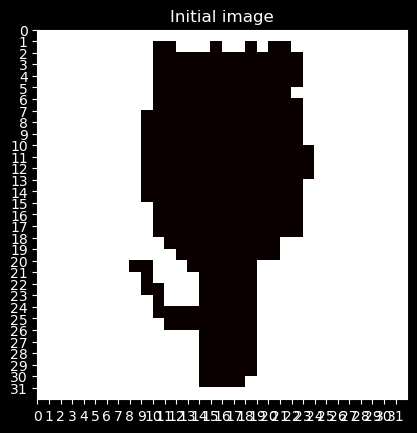

size= (32, 32)


In [26]:
def plot_image(Image, title):
    plt.title(title)
    plt.xticks(range(Image.shape[0]))
    plt.yticks(range(Image.shape[1]))
    plt.imshow(Image, extent=[  0,Image.shape[0], Image.shape[1],0,], cmap='hot')
    plt.show()
    
plot_image(imgg, 'Initial image')
print("size=",imgg.shape)

In [27]:
#we encode the intensities of image pixels as probability amplitudes of quantum states
#we use normalization for this
#we normalize the amplitudes to lie in the range (0,1)

# Convert the raw pixel values to probability amplitudes

def amplitude_encode(img_data):
    
    # Calculate the RMS value
    rms_32 = np.sqrt(np.sum(np.sum(img_data**2, axis=1)))
    
    # Create normalized image
    image_norm = []
    for arr in img_data:
        for ele in arr:
            image_norm.append(ele / rms_32)
        
    # Return the normalized image as a numpy array
    return np.array(image_norm)


#we now normalize image and get coefficients in both horizontal and vertical directions

# Horizontal: Original image
h_norm_image_32 = amplitude_encode(imgg)
print("Horizontal image normalized coefficients",h_norm_image_32)


print()
print()

# Vertical: Transpose of Original image
v_norm_image_32 = amplitude_encode(imgg.T)
print("vertical image normalized coefficients",v_norm_image_32)

print()
print("size of 1d array",h_norm_image_32.shape)
print("size of 1d array",v_norm_image_32.shape)

Horizontal image normalized coefficients [0.03745029 0.03745029 0.03745029 ... 0.03745029 0.03745029 0.03745029]


vertical image normalized coefficients [0.03745029 0.03745029 0.03745029 ... 0.03745029 0.03745029 0.03745029]

size of 1d array (1024,)
size of 1d array (1024,)


In [28]:
#we require N=log(32*32) qubits 
#N=10

data_q_32 = 10
ancillary_q_32 = 1
total_q_32 = data_q_32 + ancillary_q_32

# Initialize the amplitude permutation unitary
Amp_permutation_unitary_32 = np.identity(2**total_q_32)
print(Amp_permutation_unitary_32)
Amp_permutation_unitary_32=np.roll(Amp_permutation_unitary_32,1,axis=1)
print()
print()
print()
print("shift Amplitude permutation matrix by 1 unit to the right column wise")
print()
print(Amp_permutation_unitary_32)
print()
print("we will later use this for while applying hadamard operation to image coefficient vectors")
print()
print(Amp_permutation_unitary_32.shape)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]



shift Amplitude permutation matrix by 1 unit to the right column wise

[[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [1. 0. 0. ... 0. 0. 0.]]

we will later use this for while applying hadamard operation to image coefficient vectors

(2048, 2048)


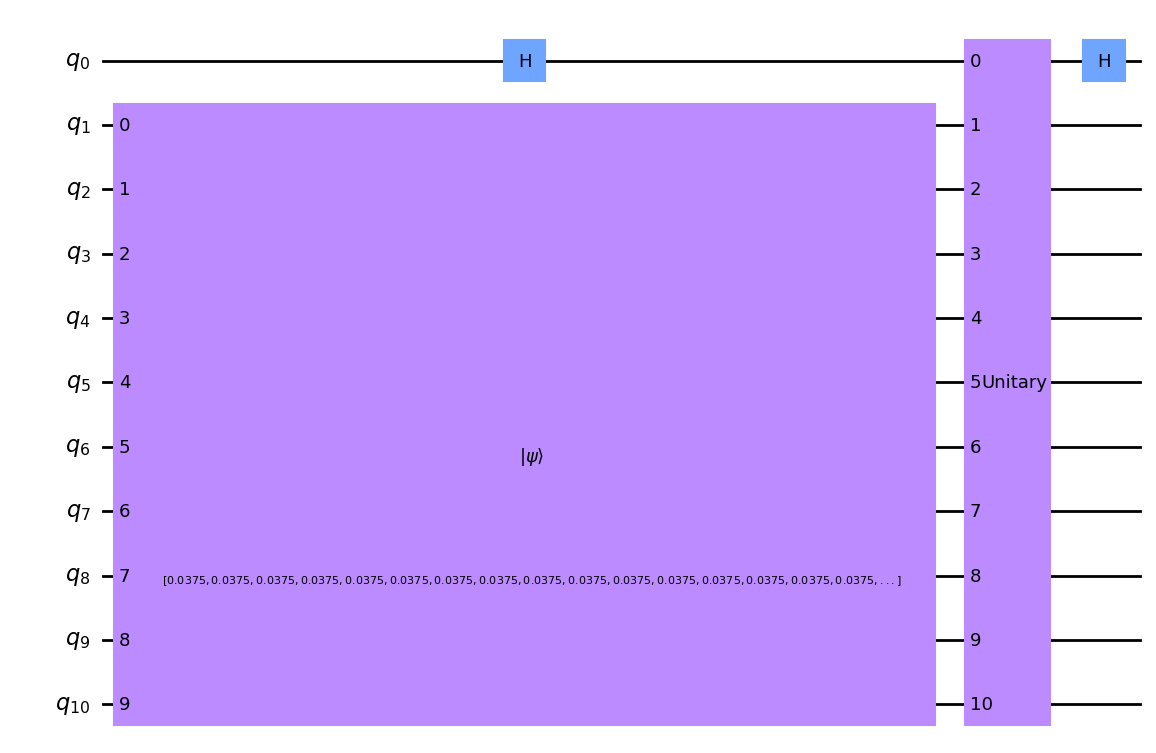

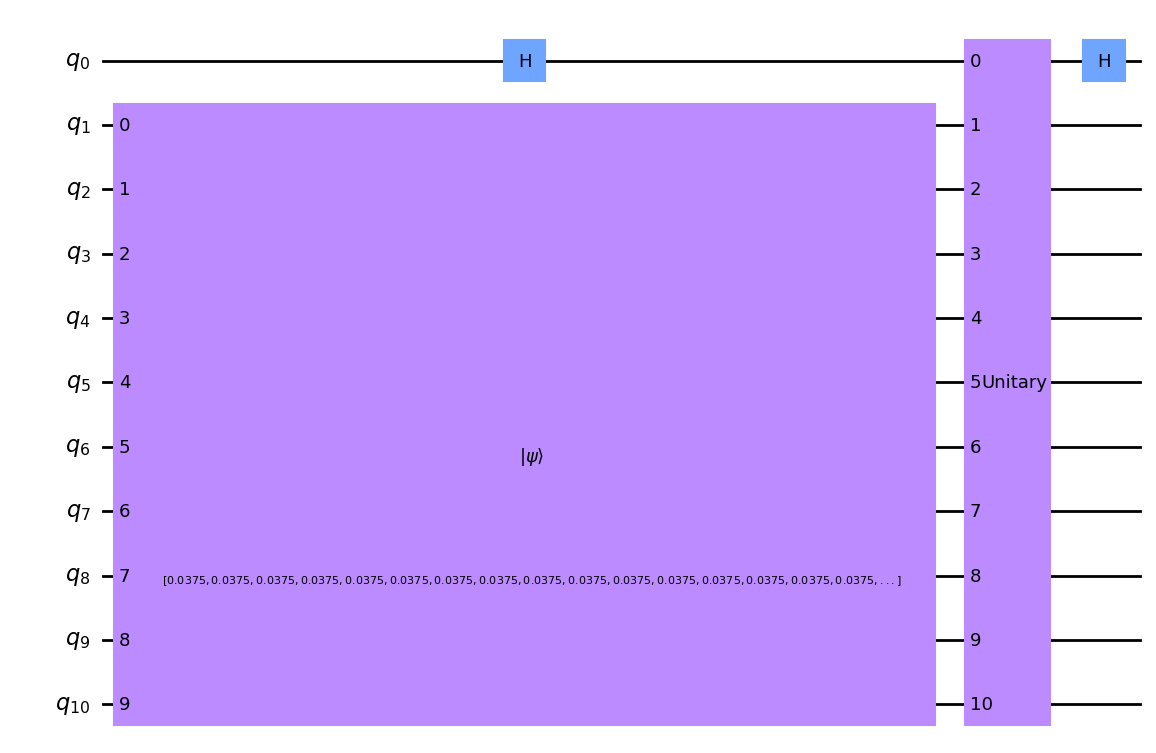

In [29]:
# Creating the circuit for horizontal scan

qc_h_32 = QuantumCircuit(total_q_32)
qc_h_32.initialize(h_norm_image_32, range(1, total_q_32))
qc_h_32.h(0)
qc_h_32.unitary(Amp_permutation_unitary_32, range(total_q_32))
qc_h_32.h(0)

display(qc_h_32.draw('mpl', fold=-1))


# Create the circuit for vertical scan
qc_v_32 = QuantumCircuit(total_q_32)
qc_v_32.initialize(v_norm_image_32, range(1, total_q_32))
qc_v_32.h(0)
qc_v_32.unitary(Amp_permutation_unitary_32, range(total_q_32))
qc_v_32.h(0)

display(qc_v_32.draw('mpl', fold=-1))

# Combine both circuits into a single list
circ_list_32 = [qc_h_32, qc_v_32]

In [30]:
# Simulating cirucits
back = Aer.get_backend('statevector_simulator')
results = execute(circ_list_32, backend=back).result()
state_vector_h_32 = results.get_statevector(qc_h_32)
state_vector_v_32 = results.get_statevector(qc_v_32)
print("size is ",state_vector_h_32.size)
from qiskit.visualization import array_to_latex
print('Horizontal scan statevector:')
display(array_to_latex(state_vector_h_32, max_size=128))
print()
print('Vertical scan statevector:')
display(array_to_latex(state_vector_v_32, max_size=128))

C:\Users\admin\AppData\Local\Temp\ipykernel_74724\3058083535.py:6: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
  print("size is ",state_vector_h_32.size)


size is  2048
Horizontal scan statevector:


<IPython.core.display.Latex object>


Vertical scan statevector:


<IPython.core.display.Latex object>

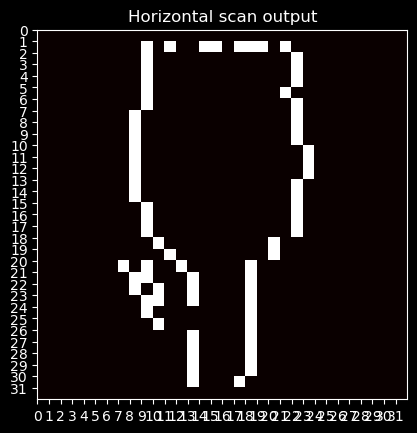

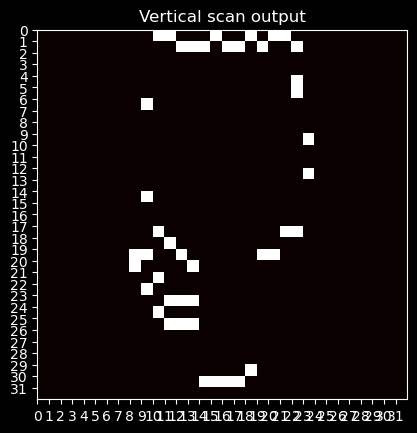

In [31]:
#  postprocessing for plotting the output (Classical)

# Defining a lambda function for thresholding to binary values
# returns true for specified Amplitude values else false
threshold = lambda amp: (amp > 1e-15 or amp < -1e-15)

# Selecting odd states from the raw statevector and
# reshaping column vector of size 64 to an 8x8 matrix
h_edge_scan_img_32 = np.abs(np.array([1 if threshold(state_vector_h_32[2*(i)+1].real) else 0 for i in range(2**data_q_32)])).reshape(32, 32)
v_edge_scan_img_32= np.abs(np.array([1 if threshold(state_vector_v_32[2*(i)+1].real) else 0 for i in range(2**data_q_32)])).reshape(32, 32).T

# Plotting the Horizontal and vertical scans
plot_image(h_edge_scan_img_32, 'Horizontal scan output')
plot_image(v_edge_scan_img_32, 'Vertical scan output')

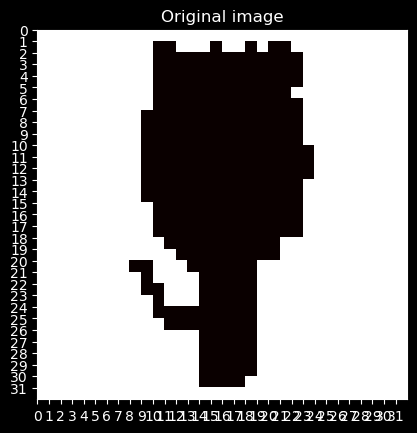

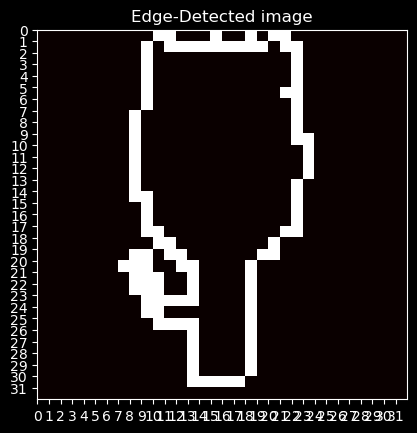

In [32]:
# Combining the horizontal and vertical component of the result by or operator
edge_scan_image_32 = h_edge_scan_img_32 | v_edge_scan_img_32

# Plotting the original and edge-detected images
plot_image(imgg, 'Original image')
plot_image(edge_scan_image_32, 'Edge-Detected image')

In [33]:
#for RGB images

In [42]:
from qiskit import *
from qiskit import IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
import skimage.color
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import math

from PIL import Image
from numpy import asarray
image = Image.open('Apple1.png')
image.show()
new_image = image.resize((32,32)).convert('1')
new_image.save('IMAGE_32.png')
new_image.show()
imgg=asarray(new_image)
print(imgg.shape)

(32, 32)


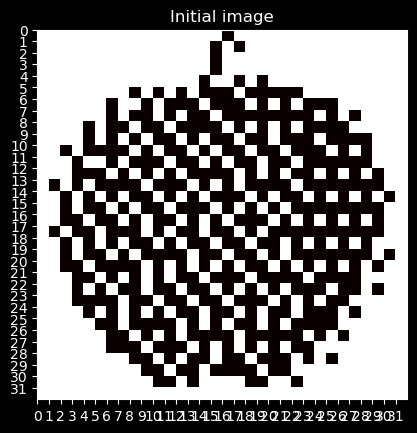

size= (32, 32)


In [44]:
def plot_image(Image, title):
    plt.title(title)
    plt.xticks(range(Image.shape[0]))
    plt.yticks(range(Image.shape[1]))
    plt.imshow(Image, extent=[  0,Image.shape[0], Image.shape[1],0,], cmap='hot')
    plt.show()
    
plot_image(imgg, 'Initial image')
print("size=",imgg.shape)

In [45]:
#we encode the intensities of image pixels as probability amplitudes of quantum states
#we use normalization for this
#we normalize the amplitudes to lie in the range (0,1)

# Convert the raw pixel values to probability amplitudes

def amplitude_encode(img_data):
    
    # Calculate the RMS value
    rms_32_rgb = np.sqrt(np.sum(np.sum(img_data**2, axis=1)))
    
    # Create normalized image
    image_norm = []
    for arr in img_data:
        for ele in arr:
            image_norm.append(ele / rms_32_rgb)
        
    # Return the normalized image as a numpy array
    return np.array(image_norm)


#we now normalize image and get coefficients in both horizontal and vertical directions

# Horizontal: Original image
h_norm_image_32_rgb = amplitude_encode(imggg)
print("Horizontal image normalized coefficients",h_norm_image_32_rgb)


print()
print()

# Vertical: Transpose of Original image
v_norm_image_32_rgb = amplitude_encode(imggg.T)
print("vertical image normalized coefficients",v_norm_image_32_rgb)

print()
print("size of 1d array",h_norm_image_32_rgb.shape)
print("size of 1d array",v_norm_image_32_rgb.shape)

Horizontal image normalized coefficients [0.00357828 0.00357828 0.00357828 ... 0.00357828 0.00357828 0.00357828]


vertical image normalized coefficients [0.00357828 0.00357828 0.00357828 ... 0.00357828 0.00357828 0.00357828]

size of 1d array (134688,)
size of 1d array (134688,)


In [46]:
#we require N=log(32*32) qubits 
#N=10

data_q_32_rgb = 10
ancillary_q_32_rgb = 1
total_q_32_rgb = data_q_32_rgb + ancillary_q_32_rgb

# Initialize the amplitude permutation unitary
Amp_permutation_unitary_32_rgb = np.identity(2**total_q_32_rgb)
print(Amp_permutation_unitary_32_rgb)
Amp_permutation_unitary_32_rgb=np.roll(Amp_permutation_unitary_32_rgb,1,axis=1)
print()
print()
print()
print("shift Amplitude permutation matrix by 1 unit to the right column wise")
print()
print(Amp_permutation_unitary_32_rgb)
print()
print("we will later use this for while applying hadamard operation to image coefficient vectors")
print()
print(Amp_permutation_unitary_32_rgb.shape)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]



shift Amplitude permutation matrix by 1 unit to the right column wise

[[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [1. 0. 0. ... 0. 0. 0.]]

we will later use this for while applying hadamard operation to image coefficient vectors

(2048, 2048)


In [47]:
# Creating the circuit for horizontal scan

qc_h_32_rgb = QuantumCircuit(total_q_32_rgb)
qc_h_32_rgb.initialize(h_norm_image_32_rgb, range(1, total_q_32_rgb))
qc_h_32_rgb.h(0)
qc_h_32_rgb.unitary(Amp_permutation_unitary_32_rgb, range(total_q_32_rgb))
qc_h_32_rgb.h(0)

display(qc_h_32_rgb.draw('mpl', fold=-1))


# Create the circuit for vertical scan
qc_v_32_rgb = QuantumCircuit(total_q_32_rgb)
qc_v_32_rgb.initialize(v_norm_image_32_rgb, range(1, total_q_32_rgb))
qc_v_32_rgb.h(0)
qc_v_32_rgb.unitary(Amp_permutation_unitary_32_rgb, range(total_q_32_rgb))
qc_v_32_rgb.h(0)

display(qc_v_32_rgb.draw('mpl', fold=-1))

# Combine both circuits into a single list
circ_list_32_rgb = [qc_h_32_rgb, qc_v_32_rgb]

QiskitError: 'Desired statevector length not a positive power of 2.'